In [1]:
import torch
import torch.nn as nn
from torch_geometric_temporal.nn import A3TGCN
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
def train_test_split(dataset, train_ratio: float = 0.9):
    spanshot_count = len(dataset)
    train_snapshots = int(train_ratio * spanshot_count)
    
    train_iterator = dataset[0:train_snapshots]
    test_iterator = dataset[train_snapshots:]

    return train_iterator, test_iterator

In [3]:
class TemporalGNN(nn.Module):
    def __init__(self, in_feats, hidden_dim, periods):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN(in_channels=in_feats,
                           out_channels=hidden_dim,
                           periods=periods)
        # Equals single-shot prediction
        self.classifier = nn.Linear(hidden_dim, periods)

    def forward(self, x, edge_index, edge_weight):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        x = self.tgnn(x, edge_index, edge_weight)
        x = F.relu(x)

        return self.classifier(x)

In [4]:
@torch.no_grad()
def evaluate(model, dataset, device):
    model.eval()

    cost = 0
    predictions = []
    labels = []
    
    for time, snapshot in enumerate(dataset):
        snapshot = snapshot.to(device)
        preds = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)

        cost += torch.sqrt(torch.mean((preds-snapshot.y)**2))

        predictions.append(preds)
        labels.append(snapshot.y)

    cost = cost / (time+1)
    cost = cost.item()
    print("Test MSE: {:.4f}".format(cost))
    return predictions, labels

In [5]:
def plot_examples(predictions, labels, prediction_idx=0, num_examples=10, timesteps=None):
    import random
    
    if not timesteps:
        timesteps = random.sample(range(0, 100), num_examples)
    
    for timestep in timesteps:
        preds = np.asarray([pred.cpu().numpy() 
                            for pred in predictions[prediction_idx][timestep]])
        labs  = np.asarray([label.cpu().numpy() 
                            for label in labels[prediction_idx][timestep]])

        plt.figure(figsize=(20,5))
        sns.lineplot(data=preds, label="pred")
        sns.lineplot(data=labs, label="true")

### Prepare data

In [6]:
pyg_data_filepath = './pyg_data.pt'
model_ckpt = './model_state_dict.pt'

dataset = torch.load(pyg_data_filepath)

train_dataset, test_dataset = train_test_split(dataset, train_ratio=0.9)

### Load trained model

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

node_features = 2
hidden_dim = 32
periods = 12

model = TemporalGNN(node_features, hidden_dim, periods).to(device)
model.load_state_dict(torch.load(model_ckpt))

<All keys matched successfully>

### Generate predictions

In [8]:
predictions, labels = evaluate(model, test_dataset, device)

Test MSE: 0.4249


### Plot random examples

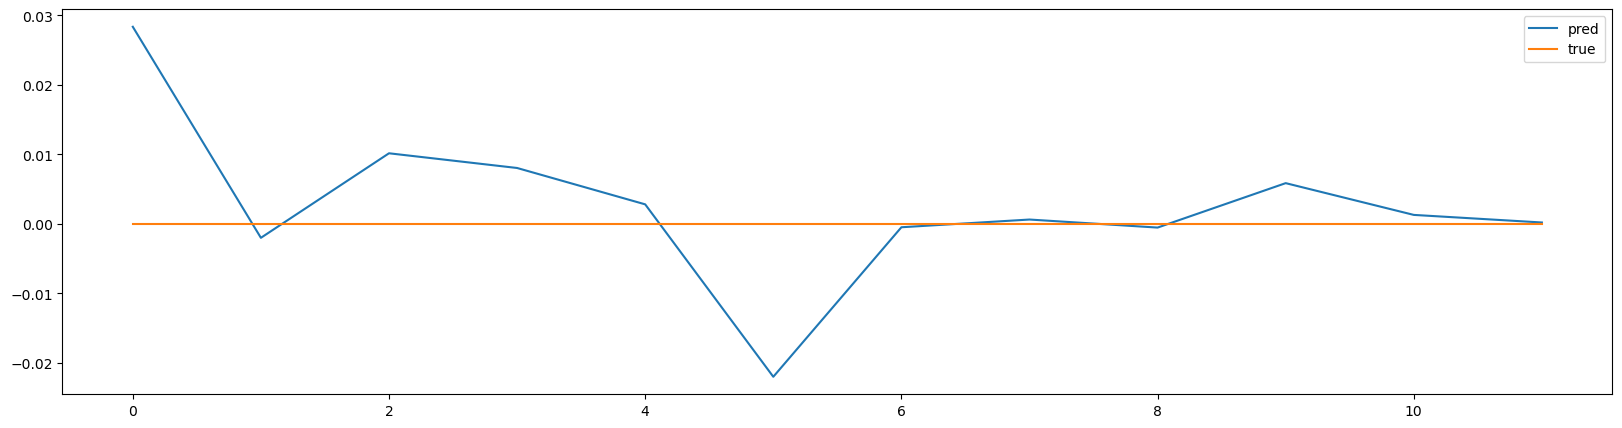

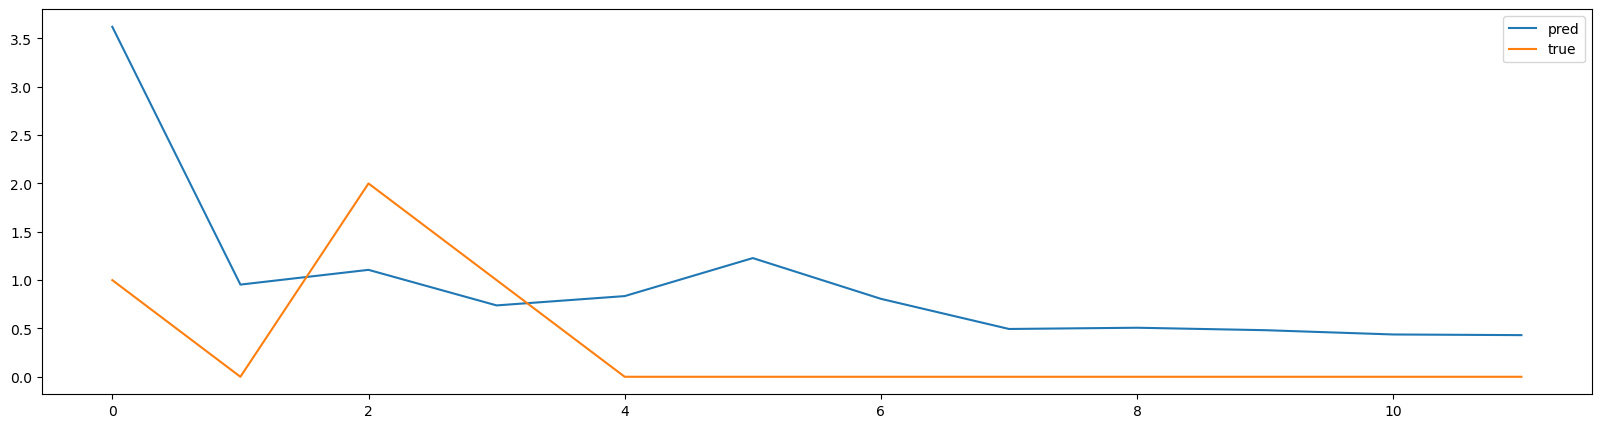

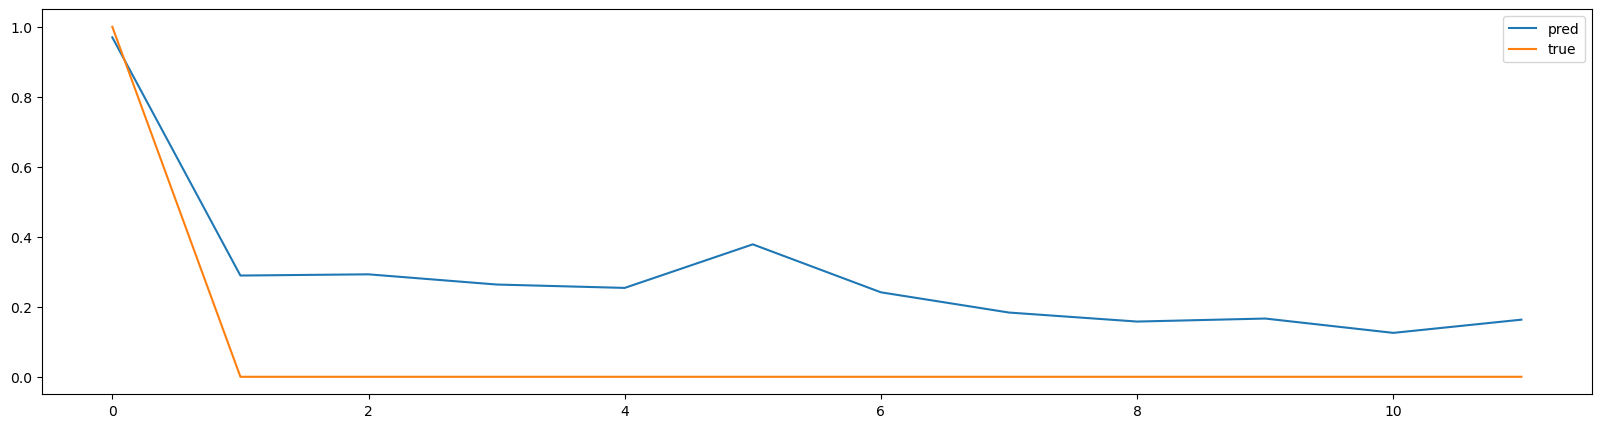

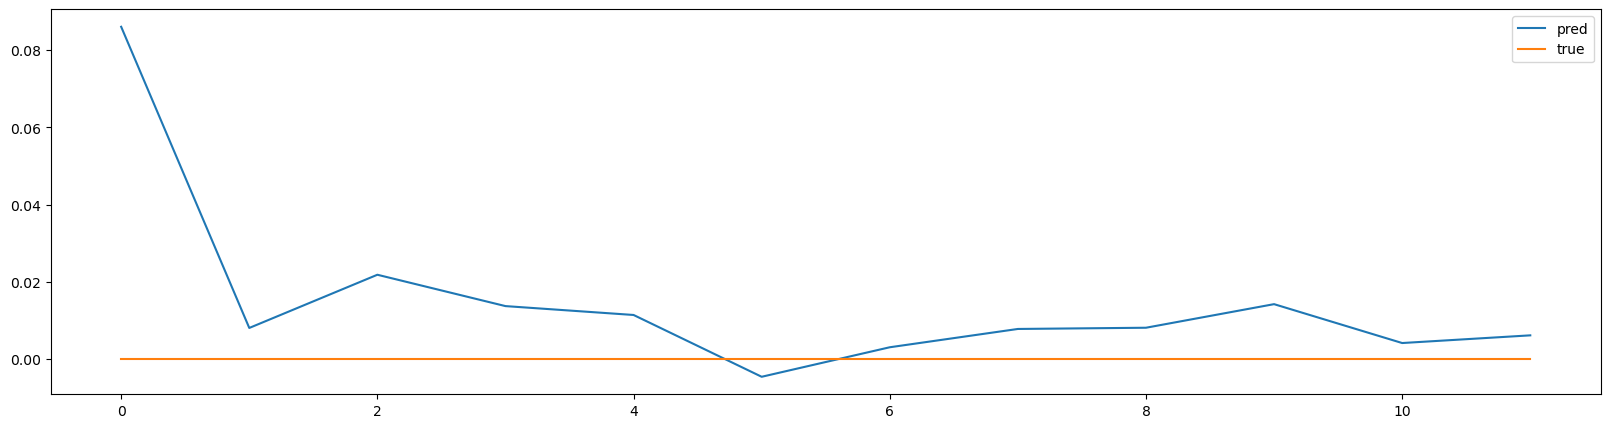

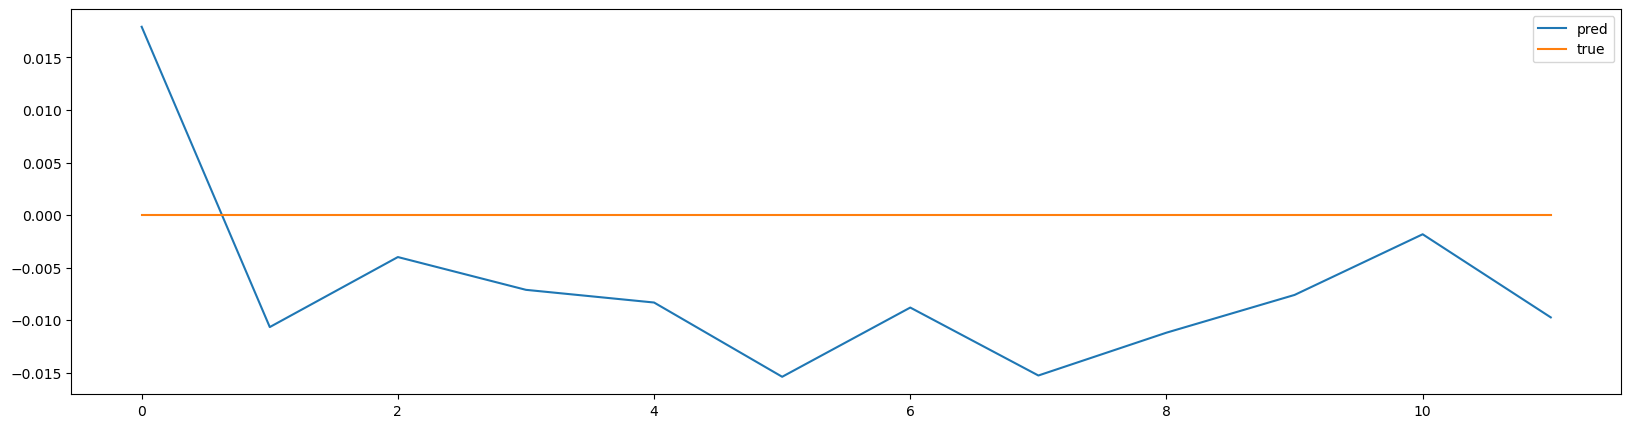

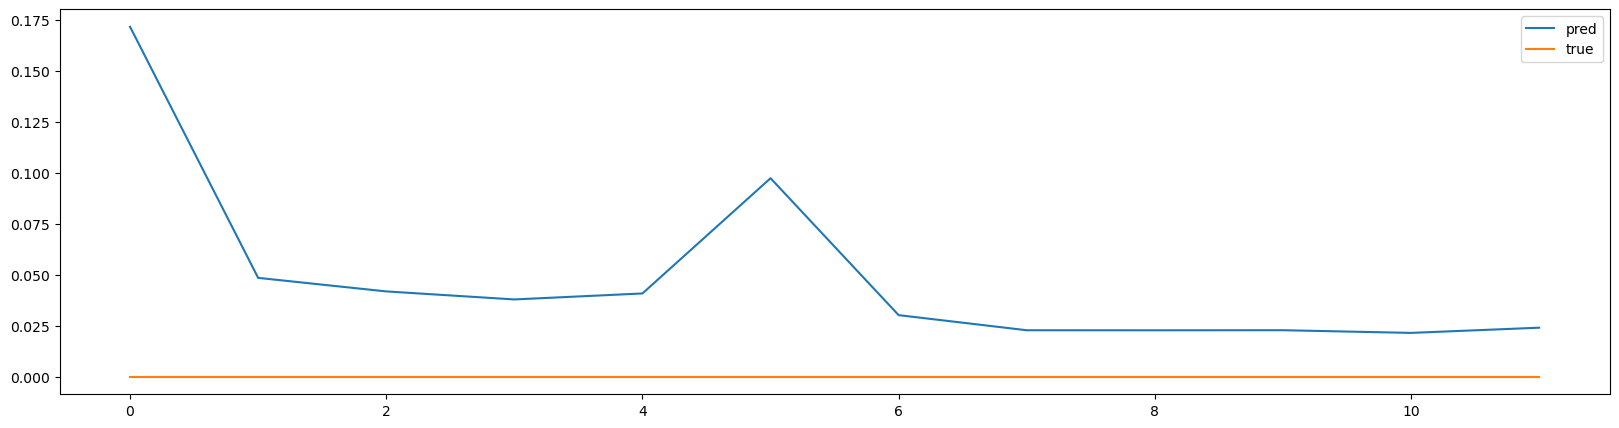

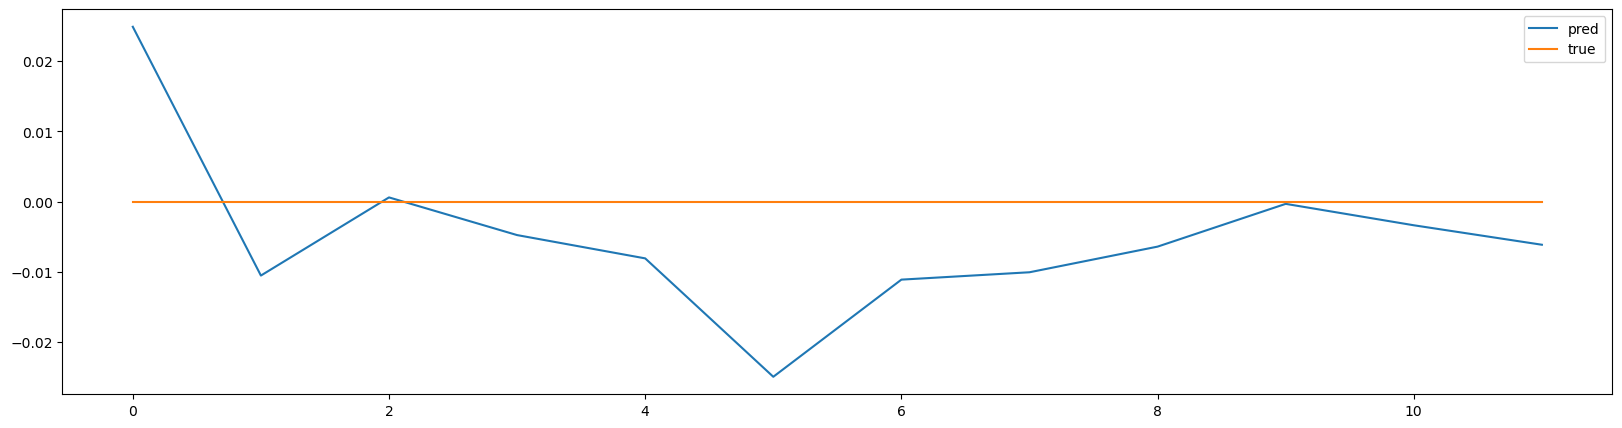

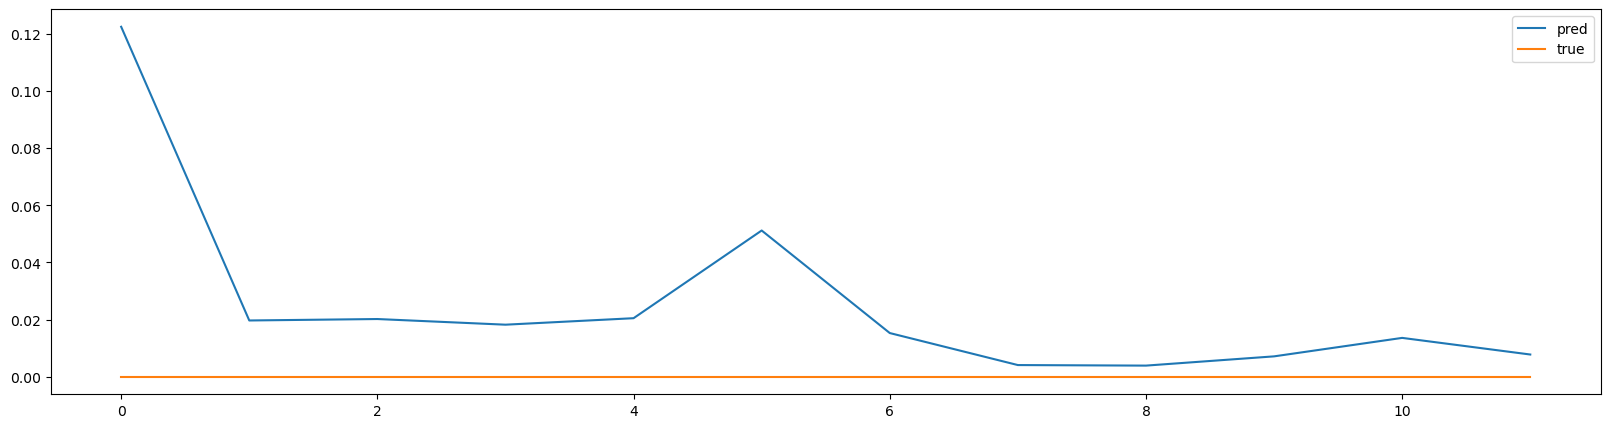

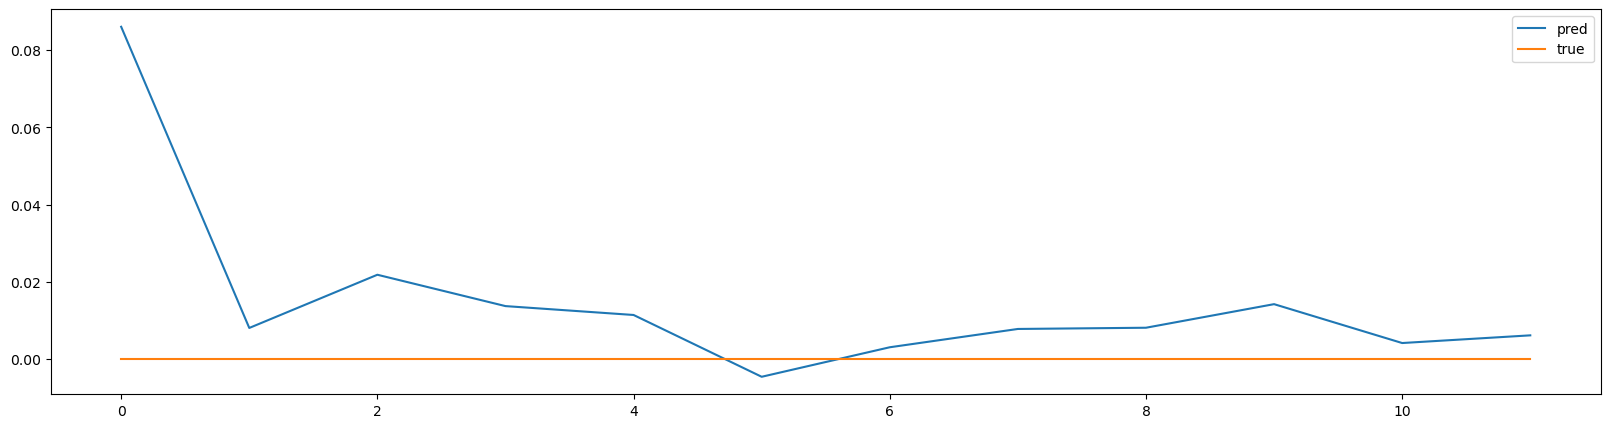

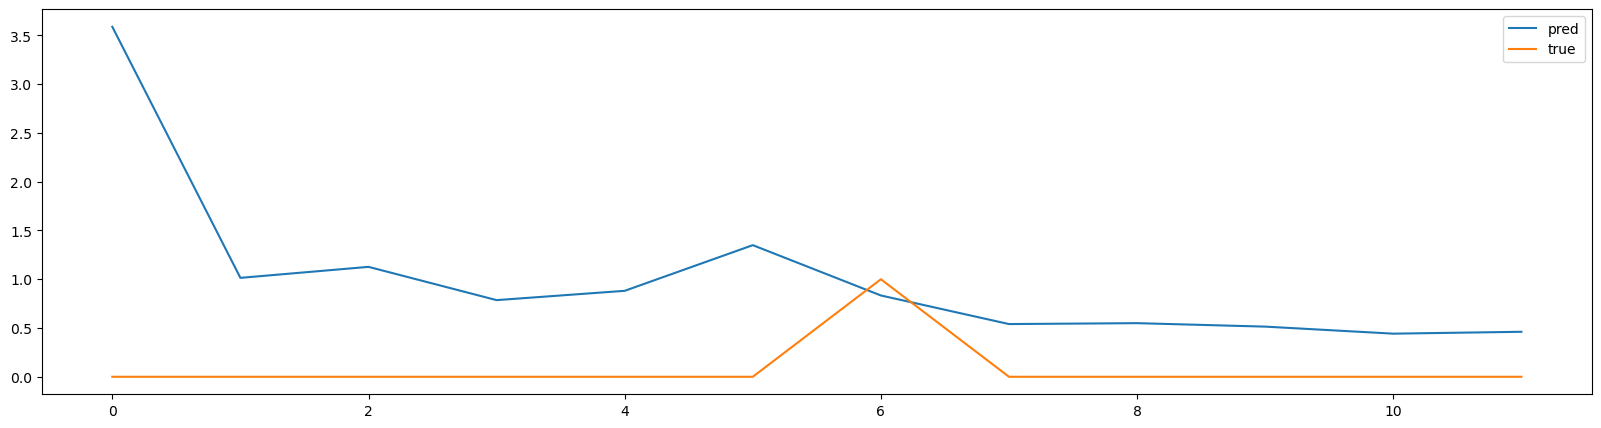

In [9]:
num_examples = 10

plot_examples(predictions, labels, num_examples=num_examples, timesteps=None)